In [2]:
import numpy
import pandas as pd
from sklearn.metrics import mean_squared_error
from tensorflow import keras
import matplotlib.pyplot as plt
from typing import Tuple, List

In [3]:
df = pd.read_csv("./data/household_power_consumption_daily.csv", parse_dates=True, index_col=0)
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
datetime,,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,14680.934
2006-12-17,3390.460,226.006,345725.30,14398.6,2033.0,4187.0,13341.0,36946.668
2006-12-18,2203.826,161.792,347373.62,9247.2,1063.0,2621.0,14018.0,19028.434
2006-12-19,1666.194,150.942,348479.00,7094.0,839.0,7602.0,6197.0,13131.900
2006-12-20,2225.748,160.998,348923.62,9313.0,0.0,2648.0,14063.0,20384.800


In [4]:
def split_data(data: numpy) -> Tuple[numpy.array, numpy.array]:
    train, test = data[1: -328], data[-328:-6]
    train = numpy.array(numpy.split(train, len(train)/7))
    test = numpy.array(numpy.split(test, len(test)/7))
    return train, test

In [5]:
train, test = split_data(df.values)
train.shape, test.shape

((159, 7, 8), (46, 7, 8))

In [6]:
def reshape_nn_input(x: numpy, n_input: int, n_output):
    data = x.reshape((x.shape[0] * x.shape[1], x.shape[2]))
    X, y = list(), list()
    first_index = 0
    for _ in range(len(data)):
        in_len = first_index + n_input
        target_len = in_len + n_output
        if target_len <= len(data):
            x_input = data[first_index:in_len, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_len:target_len, 0])
        first_index += 1
    return numpy.array(X), numpy.array(y)

In [8]:
x_train, y_train = reshape_nn_input(x=train, n_input=14, n_output=7)
x_train.shape, y_train.shape

((1093, 14, 1), (1093, 7))

In [9]:
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)

In [13]:
def lstm_model(x: numpy, y: numpy):
    timestamps, features, num_outputs = x.shape[1], x.shape[2], y.shape[1]
    model = keras.Sequential()
    model.add(keras.layers.LSTM(100, activation='relu', input_shape=(timestamps, features)))
    model.add(keras.layers.RepeatVector(num_outputs))
    model.add(keras.layers.LSTM(100, activation='relu', return_sequences=True))
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(50, activation=keras.activations.relu)))
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(1)))

    model.compile(
        loss=keras.losses.mean_squared_error,
        optimizer=keras.optimizers.Adam()
    )
    history = model.fit(x, y, epochs=30, batch_size=16, verbose=2)
    return history, model

In [14]:
history, model = lstm_model(x_train, y_train)

Epoch 1/30
69/69 - 2s - loss: 1309622.7500 - 2s/epoch - 36ms/step
Epoch 2/30
69/69 - 1s - loss: 447797.0625 - 538ms/epoch - 8ms/step
Epoch 3/30
69/69 - 1s - loss: 393650.1562 - 516ms/epoch - 7ms/step
Epoch 4/30
69/69 - 1s - loss: 279987.4375 - 544ms/epoch - 8ms/step
Epoch 5/30
69/69 - 1s - loss: 257461.1094 - 536ms/epoch - 8ms/step
Epoch 6/30
69/69 - 1s - loss: 277593.3125 - 553ms/epoch - 8ms/step
Epoch 7/30
69/69 - 1s - loss: 322177.4062 - 530ms/epoch - 8ms/step
Epoch 8/30
69/69 - 1s - loss: 290805.5625 - 536ms/epoch - 8ms/step
Epoch 9/30
69/69 - 1s - loss: 267477.6562 - 651ms/epoch - 9ms/step
Epoch 10/30
69/69 - 1s - loss: 374908.2500 - 607ms/epoch - 9ms/step
Epoch 11/30
69/69 - 1s - loss: 359625.0625 - 600ms/epoch - 9ms/step
Epoch 12/30
69/69 - 1s - loss: 286638.5312 - 590ms/epoch - 9ms/step
Epoch 13/30
69/69 - 1s - loss: 264492.9375 - 598ms/epoch - 9ms/step
Epoch 14/30
69/69 - 1s - loss: 258529.5781 - 590ms/epoch - 9ms/step
Epoch 15/30
69/69 - 1s - loss: 255689.8594 - 589ms/epoch -

In [29]:
def model_prediction(model, x: numpy, n_inputs=7):

    last_week = x[-2:][:,:,0]
    print(last_week.shape)
    last_week = last_week.reshape((1, last_week.shape[0] * last_week.shape[1], 1))

    yhat = model.predict(last_week, verbose=1)

    return yhat

In [30]:
x_train.shape

(1093, 14, 1)

In [31]:
yhat = model_prediction(model=model, x=train)

(2, 7)
1/1 [==============================] - 0s 321ms/step


In [32]:
yhat

array([[[1719.361 ],
        [1805.0228],
        [1734.3751],
        [1728.0159],
        [1705.6224],
        [1710.4314],
        [1719.6549]]], dtype=float32)

In [33]:
yhat.shape

(1, 7, 1)

In [54]:
def rmse_evaluation(actual: numpy, predicted: numpy):
    scores = list()

    for i in range(actual.shape[1]):
        rmse = numpy.sqrt(mean_squared_error(actual[:, i], predicted[:, i]))
        scores.append(rmse)
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = numpy.sqrt(s/(actual.shape[0] * actual.shape[1]))
    return score, scores

def evaluate_model(model, train, test):
    history = [obs for obs in train]
    predictions = list()

    for v in range(len(test)):
        yhat = model_prediction(model=model, x=history)
        predictions.append(yhat)
        history.append(test[v, :])
    predictions = numpy.array(predictions)
 
    score, scores = rmse_evaluation(test[:,:,0], predictions)
    return score, scores

def sunnarize_scores(name, score, scores):
    n_scores = ", ".join(["%.1f"%s for s in scores ])
    print("%s: {%.3f} %s" % (name, score, n_scores))

def model_prediction(model, x: numpy, n_inputs=14):
    data = numpy.array(x)
    data = data.reshape((data.shape[0] * data.shape[1], data.shape[2]))

    last_week = data[-n_inputs:,0]
    last_week = last_week.reshape((1, len(last_week), 1))

    yhat = model.predict(last_week, verbose=0)

    return yhat[0]

LSTM: {384.396} 381.8, 424.7, 342.7, 380.7, 363.7, 347.5, 439.1


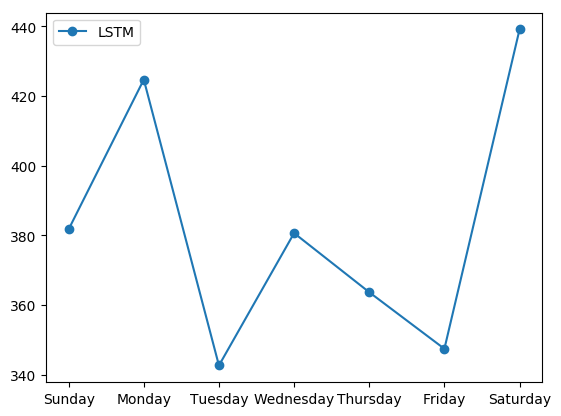

In [55]:
days = ["Sunday","Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
score, scores = evaluate_model(model=model, train=train, test=test)
sunnarize_scores("LSTM", score,scores)

plt.plot(days, scores, marker='o', label="LSTM")
plt.legend()
plt.show()